In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [4]:
train = pd.read_csv(out)

In [8]:
#add random columns to check explain
train['random_float'] = np.random.random_sample(len(train))
train['random_char'] = np.random.random_sample(len(train)).astype(str)

In [9]:
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [10]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3
random_char 32560


In [11]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [12]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [13]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cuda


In [14]:
TabModel??

Object `TabModel` not found.


# Training

In [15]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [48]:
X_valid

array([[1.40000000e+01, 4.00000000e+00, 4.57810000e+04, ...,
        3.90000000e+01, 1.52789001e-01, 1.51230000e+04],
       [2.10000000e+01, 4.00000000e+00, 2.88870000e+04, ...,
        3.90000000e+01, 3.54770158e-01, 1.06550000e+04],
       [2.30000000e+01, 4.00000000e+00, 1.93524000e+05, ...,
        3.90000000e+01, 5.13854575e-01, 1.51560000e+04],
       ...,
       [2.80000000e+01, 2.00000000e+00, 1.19199000e+05, ...,
        3.90000000e+01, 3.13661029e-01, 1.32850000e+04],
       [2.60000000e+01, 7.00000000e+00, 2.55835000e+05, ...,
        3.90000000e+01, 4.81537180e-01, 2.05910000e+04],
       [2.30000000e+01, 4.00000000e+00, 1.54374000e+05, ...,
        3.90000000e+01, 2.42844293e-02, 2.56600000e+04]])

In [16]:
max_epochs = 10 if not os.getenv("CI", False) else 2

In [17]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    max_epochs=5) 

epoch 0  | loss: 0.50587 | val_0_auc: 0.77253 | val_1_auc: 0.78369 |  0:00:03s
epoch 1  | loss: 0.40368 | val_0_auc: 0.81944 | val_1_auc: 0.82595 |  0:00:07s
epoch 2  | loss: 0.36735 | val_0_auc: 0.84496 | val_1_auc: 0.84574 |  0:00:11s
epoch 3  | loss: 0.34961 | val_0_auc: 0.87344 | val_1_auc: 0.87667 |  0:00:14s
epoch 4  | loss: 0.33651 | val_0_auc: 0.88945 | val_1_auc: 0.88483 |  0:00:17s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_1_auc = 0.88483
Best weights from best epoch are automatically used!


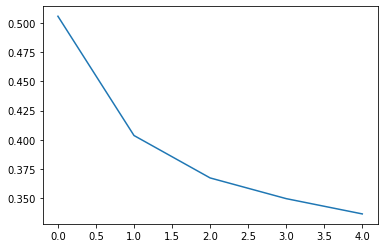

In [18]:
# plot losses
plt.plot(clf.history['loss'])

In [ ]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [20]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.8848316701719844
FINAL TEST SCORE FOR census-income : 0.8871856523050035


In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

In [ ]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [21]:
len(clf.feature_importances_)

16

In [41]:
clf.network.device

device(type='cuda')

In [42]:
from torch import device

In [46]:
device(type='cuda')

device(type='cuda')

In [22]:
clf.feature_importances_

array([0.00821373, 0.03299189, 0.0201422 , 0.10390014, 0.06889724,
       0.14025775, 0.05293414, 0.27275239, 0.00229179, 0.03900814,
       0.13438538, 0.05675076, 0.02525353, 0.02173259, 0.0072502 ,
       0.01323814])

# Local explainability and masks

In [50]:
X_test.shape

(3267, 16)

In [49]:
explain_matrix, masks = clf.explain(X_test)

In [29]:
TabModel??

Object `TabModel` not found.


In [30]:
len(explain_matrix)

3267

In [25]:
len(masks)

3

### third mask looks good revealing random columns
#### Also, it's much faster, than current `fast` implementation

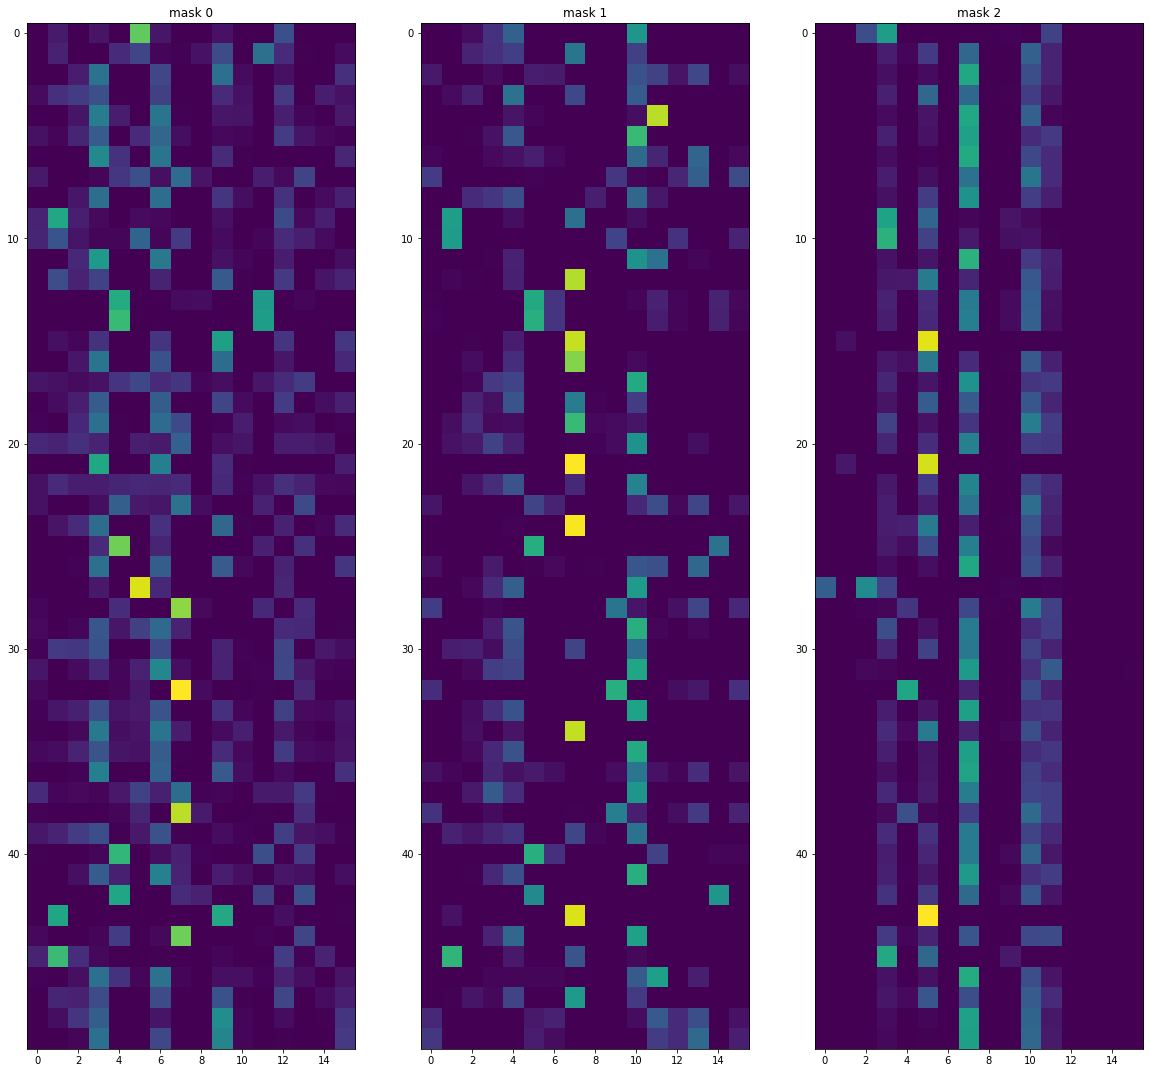

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

In [ ]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)